In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.constants import N_A
import pints
from scipy.integrate import solve_ivp
import pints.plot
sns.set_context('talk')
from lmfit import Model

In [161]:
Target_cell_number = 2e4
well_size = 50e-6
sigma = well_size*N_A/Target_cell_number
tumour_cell_radius = 7.25e-6
receptor_quant = {'500_F': 11902, 'MSX_B':1713701, '500_B':123366, '500_L':2831,
                  '250G_A':124222, '250G_C': 91578, 'MSX_A': 1843343, 'MSX_C':1584638,
                  'MSX_D': 2158, 'MSX_E': 2478, 'MSX_F': 17469, '500G_A': 120454,
                  '500G_C': 107181, '500G_D': 9824, '500G_E': 6719, '500G_H': 6341,
                  '500G_I': 8195, '500G_J': 7960, '500G_K': 2174, 'MSX_I': 52886}
t_end = 60*60*1
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]


In [162]:
df = pd.read_excel(r'/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Data/RE_ Mono vs Bivalent cell binding data - high affinity Ab/ELN354546_Tabular.xlsx')
df = df.dropna(subset=['CELL_ID']).reset_index(drop=True)
cell_ids = list(set(df['CELL_ID'].values))
cell_ids.remove('CHO_PARENT')
cell_ids.remove('MSX_A')
antibody_ids1 = list(set(df['ANTIBODY_ID'].values))
antibody_ids = [x for x in antibody_ids1 if str(x) != 'nan']
antibody_ids.remove('RSV')
print(cell_ids)
def data_extractor(df, cell_id, antibody_id):

    df1 = df.query('CELL_ID==@cell_id & ANTIBODY_ID==@antibody_id')
    mono_df = df1.query('ANTIBODY_FORMAT=="Monovalent"')
    biv_df = df1.query('ANTIBODY_FORMAT=="Bivalent"')

    concs = list(np.flip(mono_df['ANTIBODY_CONCENTRATION_MOLAR'].values))
    response_mono = list(np.flip(mono_df['RESPONSE'].values))
    response_biv = list(np.flip(biv_df['RESPONSE'].values))
    return response_mono, response_biv, concs

['500_F', '500_L', '500_B']


In [163]:
monos = []
bivs = []
concs = []
data = []
maxs =[]
rtots = []
data1_med = []
data1_high = []
data1 = []
print(antibody_ids)
for cell_id in cell_ids:
        rtot = receptor_quant[cell_id]
        rtot = rtot - 2000
        rtots.append(rtot)
        ab_id = 'RSV'
        df2new = df.query('CELL_ID==@cell_id & ANTIBODY_ID==@ab_id')
        subtract = df2new['RESPONSE'].values
        subtract = np.array(subtract[:-1])
        print(subtract)
        for antibody_id in [28015, 28008]:
                mono, biv, conc = data_extractor(df, cell_id, antibody_id)
                #remove last data point
                mono = np.array(mono[:-1])
                biv = np.array(biv[:-1])
                conc = np.array(conc[:-1])
                mono = mono-subtract
                biv = biv-subtract
                if antibody_id == 28015:
                        maximum = np.max((mono, biv))

        
                monos.append(mono/maximum)
                bivs.append(biv/maximum)
                if antibody_id == 28015:
                        data1_high.append(mono/maximum)
                        data1_high.append(biv/maximum)

                if antibody_id == 28008:
                        data1_med.append(mono/maximum)
                        data1_med.append(biv/maximum)
                concs.append(conc)

                data1.append(mono/maximum)
                data1.append(biv/maximum)

data = np.stack((data1), axis=1)
data2 = np.asarray(np.concatenate(([data1[i] for i in range(len(data1))])))
data2_med = np.asarray(np.concatenate(([data1_med[i] for i in range(len(data1_med))])))
data2_high = np.asarray(np.concatenate(([data1_high[i] for i in range(len(data1_high))])))
A0s = conc

[28008, 28015]
[15046.   2301.5  2222.   2293.   1973.5  2088.   2359.   2356.   2698.
  2407.5  2084.   2296.   2124.   2274.   2112. ]
[2413.  2558.5 2309.5 2131.  2161.  2203.5 2375.  2134.  1888.  1834.
 1763.  1897.  2019.  1753.  1974.5]
[ 9876.   5306.5  4852.5 93356.5 15003.   8240.   4844.   3769.   3232.
  3102.   2770.   2969.   2964.   3082.   2877. ]


In [164]:
print(len(data2_high), len(data2_med), data.shape)

90 90 (15, 12)


In [165]:
def model_eqns(t, z, kon, KD, k2, rtot, Ainit):
    Atot = Ainit*sigma
    k1 = kon/sigma
    A0 = Atot - z[0] - z[1]
    r = rtot - z[0] - 2*z[1]

    dA1 = 2*k1*r*A0 - (KD*kon)*z[0] - k2*r*z[0] + 2*(KD*kon)*z[1]
    dA2 = k2*z[0]*r - 2*(KD*kon)*z[1]

    return [dA1, dA2]

def model_eqns_E(t, z, kon, KD, rtot, Ainit):
    k1 = kon/sigma
    Atot = Ainit*sigma
    A0 = Atot - z[0]
    r = rtot - z[0] 

    dA1 = k1*r*A0 - (KD*kon)*z[0] 

    return [dA1]

def solve_model_individual(kon, KD, k2, rtot, A0s):
    solution = np.zeros_like(A0s)
    z0 = [0, 0]
    for i, Ainit in enumerate(A0s):
        z = solve_ivp(model_eqns, tspan, z0, method='Radau', t_eval=t, args=(kon, KD, k2, rtot, Ainit))
        A1 = z.y[0]
        A2 = z.y[1]
        bound_ab = A1[-1] + A2[-1]
        solution[i] = bound_ab
    
    return solution

def solve_model_individual_mono(kon, KD, rtot, A0s):
    solution = np.zeros_like(A0s)
    z0 = [0]
    for i, Ainit in enumerate(A0s):
        z = solve_ivp(model_eqns_E, tspan, z0, method='Radau', t_eval=t, args=(kon, KD, rtot, Ainit))
        A1 = z.y[0]
        solution[i] = A1[-1]
    
    return solution



def simulate_model_ls(A0s, kon, KD, k2, C, b):

    kon = 10**kon
    KD = 10**KD
    k2 = 10**k2
    #C = 10**C
    b = 10**b
    solutions = []
    for i in range(len(rtots)):
        solution1 = np.zeros((len(A0s)))
        solution1[:] = (solve_model_individual(kon, KD, k2, rtots[i], A0s))
        solutions.append((C*solution1 +b)/rtots[i])
        solution2 = np.zeros((len(A0s)))
        solution2[:] = (solve_model_individual_mono(kon, KD, rtots[i], A0s))
        solutions.append((C*solution2 +b)/rtots[i])
    
    solution = np.asarray(np.concatenate(([solutions[i] for i in range(len(solutions))])))
    return solution

In [166]:
ls_model = Model(simulate_model_ls)
print(ls_model.param_names)
print(ls_model.independent_vars)
ls_model.set_param_hint('kon', min = 4, max = 7)
ls_model.set_param_hint('KD', min = -10, max = -8)
ls_model.set_param_hint('k2', min = -10, max = -2)
ls_model.set_param_hint('C', min = -2, max = 3)
ls_model.set_param_hint('b', min = -6, max = 10)

parameters = ls_model.make_params(kon=5, KD = -9, k2=-4, C=0.1, b=2)

result = ls_model.fit(data2_med, parameters, A0s=A0s)

['kon', 'KD', 'k2', 'C', 'b']
['A0s']


In [167]:
print(result.fit_report())

[[Model]]
    Model(simulate_model_ls)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 115
    # data points      = 90
    # variables        = 5
    chi-square         = 2.17106309
    reduced chi-square = 0.02554192
    Akaike info crit   = -325.213345
    Bayesian info crit = -312.714296
    R-squared          = 0.63493386
[[Variables]]
    kon:  5.49555685 +/- 0.00309144 (0.06%) (init = 5)
    KD:  -8.88511043 +/- 0.23985224 (2.70%) (init = -9)
    k2:  -9.55064595 +/- 29.3360613 (307.16%) (init = -4)
    C:    0.48248245 +/- 0.03815198 (7.91%) (init = 0.1)
    b:   -2.78366622 +/- 7249.63489 (260434.78%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(KD, C)   = +0.4490
    C(C, b)    = -0.2996
    C(k2, C)   = +0.2139
    C(kon, KD) = +0.1830
    C(KD, b)   = +0.1587
    C(k2, b)   = -0.1321
    C(kon, b)  = -0.1057


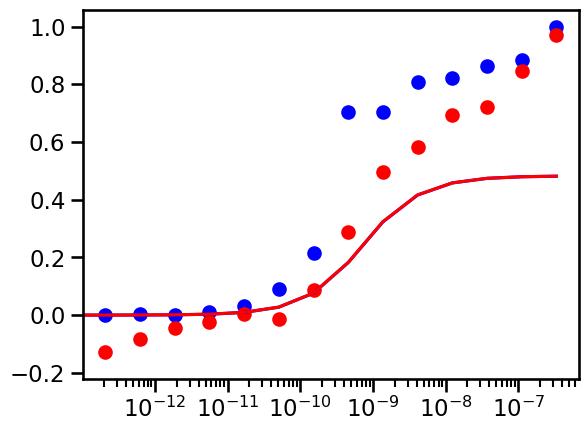

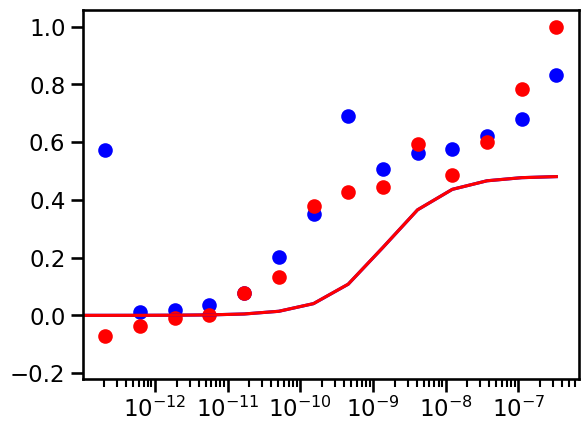

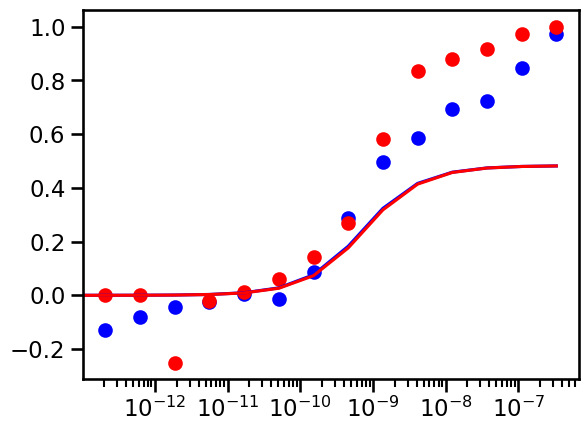

In [168]:
param_results = result.best_values
vals = simulate_model_ls(A0s, param_results['kon'], param_results['KD'], param_results['k2'], param_results['C'], param_results['b'])
j = len(A0s)
for i in range(len(rtots)):
    plt.figure()
    plt.scatter(A0s, data2_high[i*j:j*(i+1)], c='blue')
    plt.scatter(A0s, data2_high[(i+2)*j:j*(i+3)], c='red')
    plt.plot(A0s, vals[i*j:j*(i+1)], c='blue')
    plt.plot(A0s, vals[(i+2)*j:j*(i+3)], c='red')
    plt.xscale('log')
